# A Jupyter notebook application for instant flowline feature extraction

By George Lu, for a Glaciology class project


In the broadest sense, a flowline for a glacier is a line connecting the top of the glacier with the terminus that follows the flow pattern of the ice. It is useful to be able extract glacier features along a flowline as it offers a good 1-D slice of data that still captures most of the glaciers physics. Reducing a glacier to a flowline generates important inputs for 1-D ice sheet models used for prediction, such as glacier length (e.g. Radic et al., 2014).

The goal of this project/exercise is to try and be able to construct flowlines along the Antarctic Ice Sheet (AIS), given any initial point on the ice sheet. The AIS is much less confined by topography compared to alpine valley glaciers, for which existing flowline algorithms exist (Le Bris and Paul, 2013). We will compare my flowline methods against each other, before using them to extract other features along the flowline in an example problem. 



## Part 1: Investigating different methods for flowline selection
We start by importing relevant libraries and datasets. For this section, we will use the [measured velocity data](https://drive.google.com/file/d/1Mbo6XzZjw1YCItBeA9DOXqW5iVpXzEUU/view?usp=sharing) and [surface elevation/topography data](https://drive.google.com/file/d/1bh88YHW0iv-p3TwxseJRXXDO-2FZoBQ0/view?usp=sharing) used in an [earlier practical for class](https://github.com/ldeo-glaciology/glaciology_practical/blob/main/notebooks/P6.ipynb). We will also extend our methodology to additional data sets, with our example using [surface mass balance data from MAR](https://zenodo.org/record/2547638#.ZFBdnOzMIbk), a regional climate model (Agosta and Fettweis, 2019). 

In [1]:
import scipy.io
import scipy.interpolate
from scipy.integrate import solve_ivp
from netCDF4 import Dataset
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
s = scipy.io.loadmat("MeasuredSpeed.mat")
b = scipy.io.loadmat("BedMap2_forP4.mat")

Vx = s['Vx']
Vy = s['Vy']
X = s['x']
X = np.squeeze(X)

Y = s['y']
Y = np.squeeze(Y)

elev_bed = b['elev_bed']
elev_surf = b['elev_surf']
slope = b['slope']
thickness = b['thickness']
x_bedmap = b['x_bedmap'][0,:]
y_bedmap = b['y_bedmap'][:,0]

Importing the MAR data. We will load the mean annual surface mass balance from 1979-2017.

In [2]:
mar_data = Dataset('MAR-ERA-Interim_smb_1979-2017_ave.nc4')
x_mar = mar_data.variables['x'][:].data*1000
y_mar = mar_data.variables['y'][:].data*1000
smb = np.mean(mar_data.variables['smb'][:].data,axis=(0,1))

Let's plot a streamplot of the velocities. This will help us get a sense of the flowlines along the glacier. We will also select 8 points for testing the various methods for determining a flowline. The `matplotlib` function `streamplot` plots the streamlines for a given velocity field. These streamlines, which are the lines that are tangential to the velocity field, can flow from a given point to the edge of a glacier, and by definition track the flow of ice. Consequently, I choose to use these streamlines to be analagous to a "flowline" for portions of an ice sheet.

The code snippet below generates the streamplot, and also marks the initial points for our testing of different streamline functions. Interestingly enough, even though it rapidly generates these lines for the entire field, we're unable to select a specific point, hence our development of our own method

<ipython-input-3-2ed99678ab55>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');


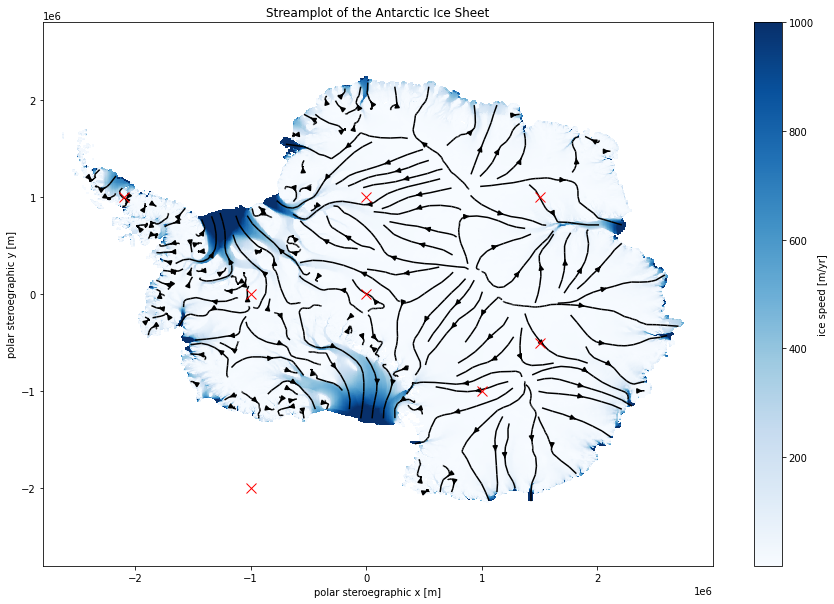

In [3]:
x_array = [-2.1e6,0,1.5e6,-1e6,0,1e6,1.5e6,-1e6]
y_array = [1e6,1e6,1e6,0,0,-1e6,-0.5e6,-2e6]
plt.figure(figsize=(15,10))
speed = np.sqrt(Vx**2 + Vy**2)
speed[speed == 0] = 'nan'
plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
plt.colorbar(label = 'ice speed [m/yr]')
plt.streamplot(X, Y, Vx,Vy, density=2,color='black')
for i in range(len(x_array)):
    plt.plot(x_array[i],y_array[i],c='red',marker='x',ms=10)
plt.title('Streamplot of the Antarctic Ice Sheet')
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]')
plt.show()


First, lets determine the flowline using this velocity data that has been observed. My first approach is to use the directions indicated by the velocities to conduct a search of sorts. I figure out the nearest grid point that the direction is pointing to, "move" to that point, and calculate its direction to find the next point. I iterate this until I've moved to the edge of the ice, or until the solver doubles back onto its own path to form a loop. This second case is not physical, but I need to consider it to prevent an infinite loop with the solver. We refer to this function as `flow_vel_dir`.

In [4]:
def flow_vel_dir(x,y,Vx,Vy,X,Y,grid_size=5000):
    interp_vx = scipy.interpolate.RegularGridInterpolator((Y, X), Vx)((y,x))
    interp_vy = scipy.interpolate.RegularGridInterpolator((Y, X), Vy)((y,x))
    speed = np.sqrt(interp_vx**2 + interp_vy**2)
    x_flow = [x]
    y_flow = [y]
    Set = set()
    Set.add((x, y))
    while not np.isnan([x,y]).any():
        speed = np.sqrt(interp_vx**2 + interp_vy**2)
        x = X[np.abs(X - x-grid_size*interp_vx/speed).argmin()]
        y = Y[np.abs(Y - y-grid_size*interp_vy/speed).argmin()]
        interp_vx = scipy.interpolate.RegularGridInterpolator((Y, X), Vx)((y,x))
        interp_vy = scipy.interpolate.RegularGridInterpolator((Y, X), Vy)((y,x))
        x_flow.append(x)
        y_flow.append(y)
        #print(f'x={x},y={y}')
        #print(interp_vx)
        if (x, y) in Set:
            break
        Set.add((x, y))
        
    return x_flow[:-2],y_flow[:-2]


Running this function with our test of initial points, we generate the plot below. We also time it for future comparison.

<ipython-input-5-2ba29bc224e2>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
<ipython-input-4-52697eb7d007>:11: RuntimeWarning: invalid value encountered in double_scalars
  x = X[np.abs(X - x-grid_size*interp_vx/speed).argmin()]
<ipython-input-4-52697eb7d007>:12: RuntimeWarning: invalid value encountered in double_scalars
  y = Y[np.abs(Y - y-grid_size*interp_vy/speed).argmin()]


total time = 0.3518850803375244


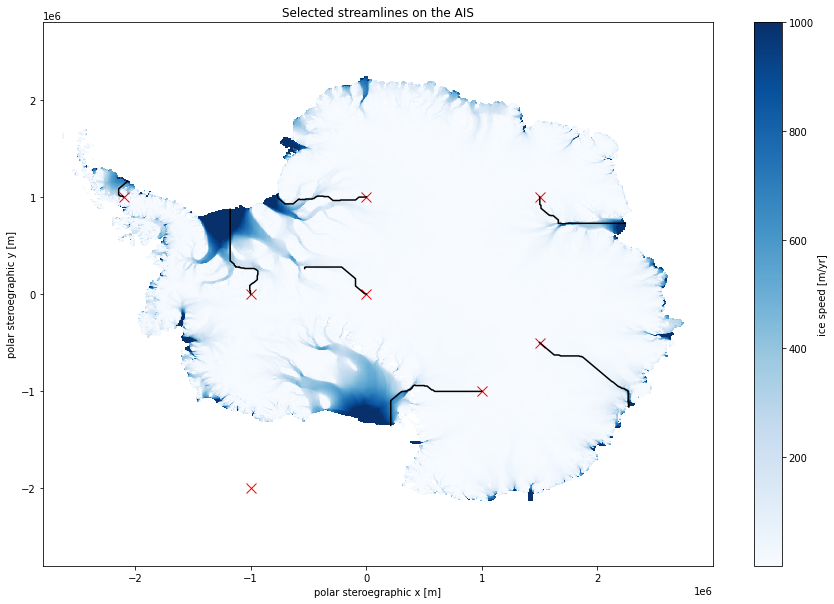

In [5]:
plt.figure(figsize=(15,10))
plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
plt.colorbar(label = 'ice speed [m/yr]')
t0 = time.time()
for i in range(len(x_array)):
    xi,yi = flow_vel_dir(x_array[i],y_array[i],Vx,Vy,X,Y)
    plt.plot(x_array[i],y_array[i],c='red',marker='x',ms=10)
    plt.plot(xi,yi,color='black')
t1 = time.time()
print(f"total time = {t1-t0}")
plt.title('Selected streamlines on the AIS')
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]')
plt.show()


Looking at these lines, they are a bit jagged in nature, especially once they reach the shelf. I think this is because of my search radius, which might get messed up when there’s faster velocities. We also see one of the flowlines fail to reach the edge of the ice, which is strange. This could be an area where the velocity ended up pointing towards an existing point on the flowline. Regardless, these lines could be improved. We move on to our next method as a result.

For my next method, I assume that the velocity field is in a steady state and take advantage of this. In an unvarying velocity field, the streamline is equivalent to the pathline, which is the path a particle takes given the velocity field. This fits well with the intent of my project which is to determine the path the ice would flow given any intial point. So knowing the definition of the pathline, we can treat this problem as an initial value problem. We use our defined points as the initial point, and then the velocity fields are treated as the function that describes the evolution. We can then iterate in time to determine the path. The function is defined below.

In [6]:
# flowline extraction using IVP solver

def flow_from_grad(x,y,Vx,Vy,X,Y,time=1e5):
    fx = scipy.interpolate.RegularGridInterpolator((Y, X), Vx, bounds_error=False, fill_value=None)
    fy = scipy.interpolate.RegularGridInterpolator((Y, X), Vy, bounds_error=False, fill_value=None)
    def f(t, y):
        return np.squeeze([fy(y), fx(y)])
    sol = solve_ivp(f, [0, time], [y,x], t_eval=np.arange(0,time,1))
    return sol.y[1], sol.y[0]


We now use this to generate the same plot as before, but with this new method. We see that the flowlines are a lot smoother, and actually reach the edges. We also see that the total time is not much faster. One drawback of this method compared to my search method is that no matter what, it iterates through the determined amount of timesteps, so when the flowline has reached the terminus, it doesn't automatically stop. I think this reason is why it takes slightly longer than my search method, which stops immediately once the search reaches the boundary. A future improvement would therefore be to implement an adaptive time cutoff for the IVP method. 

<ipython-input-7-fac5f669b1bf>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');


total time = 0.41782402992248535


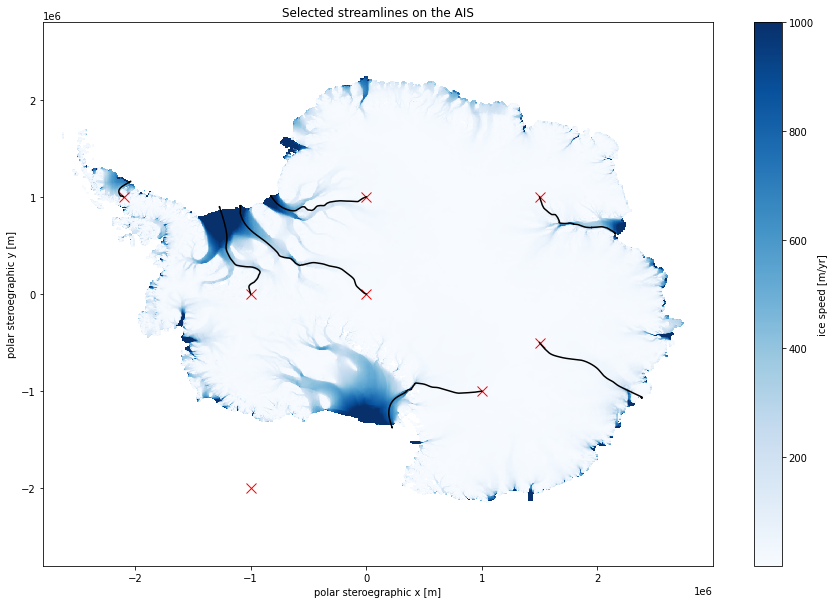

In [7]:
plt.figure(figsize=(15,10))
plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
plt.colorbar(label = 'ice speed [m/yr]')
t0 = time.time()
for i in range(len(x_array)):
    xi,yi = flow_from_grad(x_array[i],y_array[i],Vx,Vy,X,Y)
    plt.plot(x_array[i],y_array[i],c='red',marker='x',ms=10)
    plt.plot(xi,yi,color='black',label='pathline')
t1 = time.time()
print(f"total time = {t1-t0}")
plt.title('Selected streamlines on the AIS')
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]')
plt.show()

Finally, I made an initial effort in generating a flowline using the surface slope of the ice sheet, with the idea that flow tends towards steeper stopes. I define a similar search function as my first method where given an initial point, we search for surrounding slopes that are steeper than it, which determines the direction of the flow.

In [8]:
def flow_from_slope(x,y,slope,x_bedmap,y_bedmap):
    i = np.abs(x_bedmap - x).argmin()
    j = np.abs(y_bedmap - y).argmin()
    slope_i = slope[i,j]
    x_array = []
    y_array = []
    while not np.isnan(slope_i):
        x_array.append(x_bedmap[i])
        y_array.append(y_bedmap[j])
        slopes = [slope[i+1,j],slope[i-1,j],slope[i,j+1],slope[i,j-1]]
        search_dir = (slopes-slope_i).argmax()
        #print(slopes[search_dir])
        if slopes[search_dir]-slope_i <= 0:
            break
        elif search_dir == 0:
            i += 1
        elif search_dir == 1:
            i -= 1
        elif search_dir ==2:
            j += 1
        elif search_dir ==3:
            j -= 1
        slope_i = slope[i,j]
        
    return x_array, y_array

Trying to implement this, we see that the streamlines don't generate. Additional commentary on why this fails follows the plot, but we can tell already that the slope data is quite noisy in the plot below, so simply searching for the steepest slope may not work. Consequently, additional efforts are needed in the future for determining streamlines from a single snapshot, as the velocity fields require a time series of measurements of the ice. 

<ipython-input-9-9c919331fd23>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_bedmap, y_bedmap, slope,vmax=0.01, cmap = 'Blues');


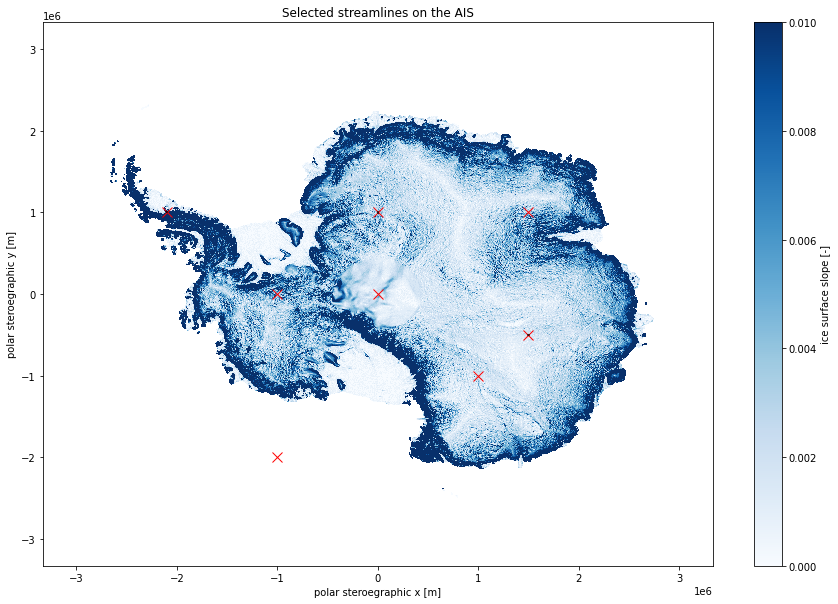

In [9]:
plt.figure(figsize=(15,10))
plt.pcolormesh(x_bedmap, y_bedmap, slope,vmax=0.01, cmap = 'Blues');
plt.colorbar(label = 'ice surface slope [-]')
for i in range(len(x_array)):
    xi,yi = flow_from_slope(x_array[i],y_array[i],slope,x_bedmap,y_bedmap)
    plt.plot(x_array[i],y_array[i],c='red',marker='x',ms=10)
    plt.plot(xi,yi,color='black')
    
plt.title('Selected streamlines on the AIS')
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]')
plt.show()

## Part 2: Using an interactive plot to pick a flowline

Now, following the method from practical, I use a interactive window for selecting a flowline. But rather than picking 2 points for a transect, we now only need to select 1 point and my code will generate a flowline. The code snippet below generates a window for selecting the flowline, and returns x,y coordinates that represent the flowline. These coordinates can then be used for pulling out variables of interest through interpolation. 

<ipython-input-10-6d0963257ed4>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');


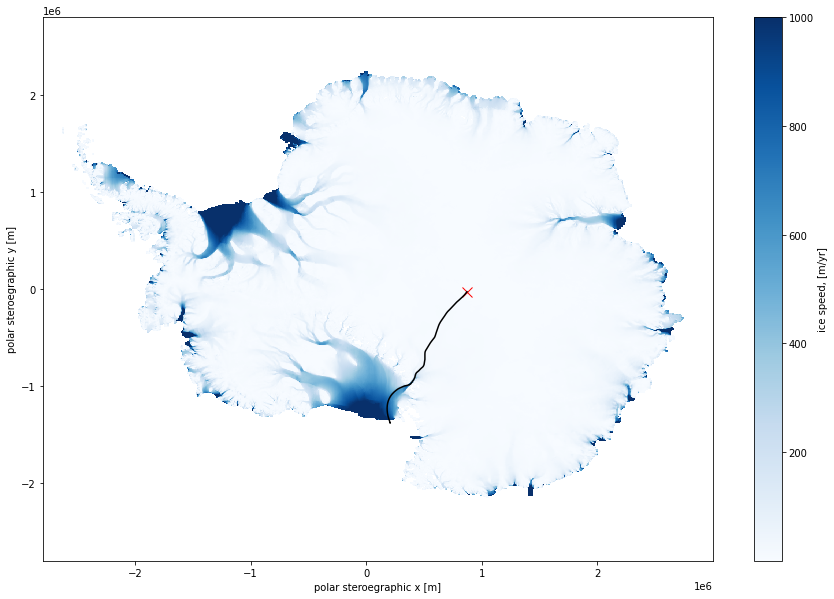

In [10]:
import matplotlib
matplotlib.use( 'tkagg' )
plt.figure(figsize=(15,10))
speed = np.sqrt(Vx**2 + Vy**2)
speed[speed == 0] = 'nan'
plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]');
plt.colorbar(label = 'ice speed, [m/yr]')
p = plt.ginput(1)
x1, y1 = p[0]
xi,yi = flow_from_grad(x1,y1,Vx,Vy,X,Y,1e6)
plt.plot(x1,y1,c='red',marker='x',ms=10)
plt.plot(xi,yi,color='black',label='pathline')

## Part 3: Evaluating values along a flowline

Now we can use a picked flowline along with interpolation techniques to extract values of interest from other datasets. Let's look at the ice slope. I'm specifying a flowline in a fast flowing area ending in an ice shelf, where I suspect that a straight transect might not properly represent the data the best. Comment out the first 3 lines to use the flowline picked in Part 2. Also comment out the `plt.xlim()` and `plt.ylim()` lines to better see the plot for a custom-defined flowline.

<ipython-input-11-cc16819026ec>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');


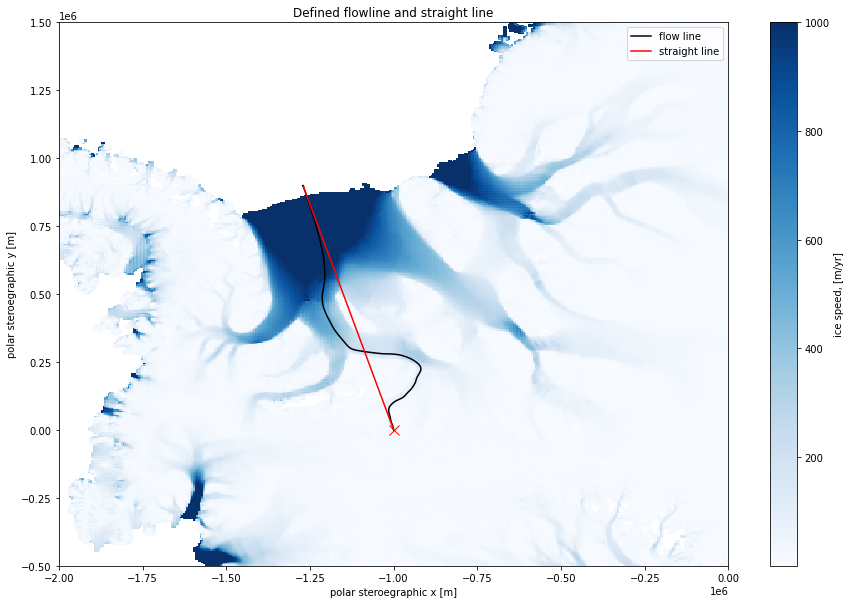

In [11]:
%matplotlib inline
x1,y1 = -1e6,0
xi,yi = flow_from_grad(x1,y1,Vx,Vy,X,Y)
x_straight = np.linspace(xi[0],xi[-1],len(xi))
y_straight = np.linspace(yi[0],yi[-1],len(yi))
plt.figure(figsize=(15,10))
speed = np.sqrt(Vx**2 + Vy**2)
speed[speed == 0] = 'nan'
plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]');
plt.colorbar(label = 'ice speed, [m/yr]')
plt.plot(x1,y1,c='red',marker='x',ms=10)
plt.plot(xi,yi,color='black',label='flow line')
plt.plot(x_straight,y_straight,color='red',label='straight line')
plt.xlim([-2e6,0])
plt.ylim([-0.5e6,1.5e6])
plt.title('Defined flowline and straight line')
plt.legend() 

Now we define our fields to interpolate.

In [12]:
slope_interp = scipy.interpolate.RegularGridInterpolator((y_bedmap, x_bedmap), slope)
thick_interp = scipy.interpolate.RegularGridInterpolator((y_bedmap, x_bedmap), thickness)
speed_interp = scipy.interpolate.RegularGridInterpolator((Y, X), speed)
smb_interp = scipy.interpolate.RegularGridInterpolator((y_mar, x_mar), smb)

We also define a smoothing function, in case we have noisy data.

In [13]:
def smooth(arr,window_size=100):
    
    return np.convolve(arr, np.ones(window_size) / window_size, mode = 'same')


Let's start by looking at the slopes along these two lines. The below code snippets generate the profile plots, and immediately we see why our slope method failed. Even with smoothing, we can see that the slope is very variable along both our defined flowline and the straight line transect. However, we can see that the slope profile along our flowline follows what we'd expect the ice sheet to behave like, as in it has a more realistic sheet-shelf transition. On the other hand the straight line, which could be an intuitive transect to draw if we didn't see the velocity data, dips in and out of regions of high velocity, which results in much more variable slopes.

Text(0.5, 1.0, 'Comparing slopes along different lines')

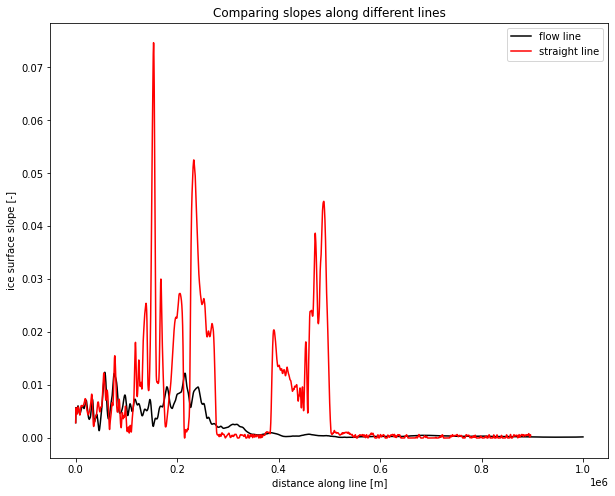

In [14]:
plt.figure(figsize=(10,8))
d = np.sqrt(np.diff(yi)**2 + np.diff(xi)**2)
d = np.insert(np.cumsum(d), 0 , 0)
plt.plot(d,smooth(slope_interp((yi,xi))),color='black',label='flow line')
d_s = np.sqrt(np.diff(y_straight)**2 + np.diff(x_straight)**2)
d_s = np.insert(np.cumsum(d_s), 0 , 0)
plt.plot(d_s,smooth(slope_interp((y_straight,x_straight))),color='red',label='straight line')
plt.ylabel('ice surface slope [-]')
plt.xlabel('distance along line [m]')
plt.legend()
plt.title('Comparing slopes along different lines')

We repeat this with the thickness data. Again, we see that our flowline has much smoother profiles than the straight transect.

Text(0.5, 1.0, 'Comparing thickness along different lines')

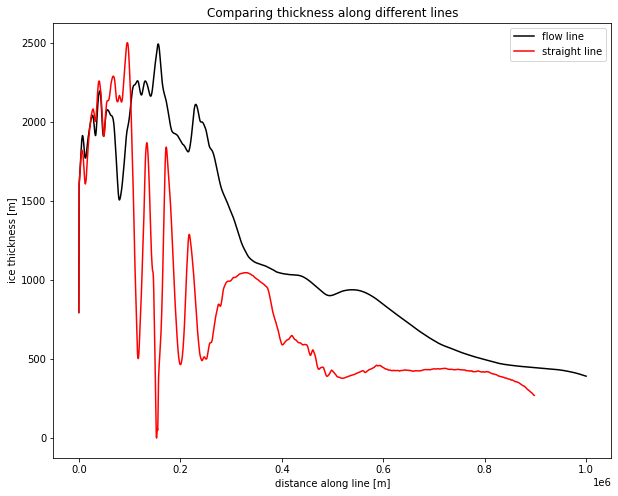

In [15]:
plt.figure(figsize=(10,8))
d = np.sqrt(np.diff(yi)**2 + np.diff(xi)**2)
d = np.insert(np.cumsum(d), 0 , 0)
plt.plot(d,smooth(thick_interp((yi,xi))),color='black',label='flow line')
d_s = np.sqrt(np.diff(y_straight)**2 + np.diff(x_straight)**2)
d_s = np.insert(np.cumsum(d_s), 0 , 0)
plt.plot(d_s,smooth(thick_interp((y_straight,x_straight))),color='red',label='straight line')
plt.ylabel('ice thickness [m]')
plt.xlabel('distance along line [m]')
plt.legend()
plt.title('Comparing thickness along different lines')

The surface mass balance (SMB) profile is also smoother for our flowline, as shown below. At first, this didn't make much sense since I felt that precipitation and temperature patterns were more dependent on latitude, so the straight transect would be equally smooth. However, given the regions of large thickness changes from our previous plot, the large wiggle in SMB for the straight line is likely due to precipitation/temperature varying largely with altitude as well. 

Text(0.5, 1.0, 'Comparing SMB along different lines')

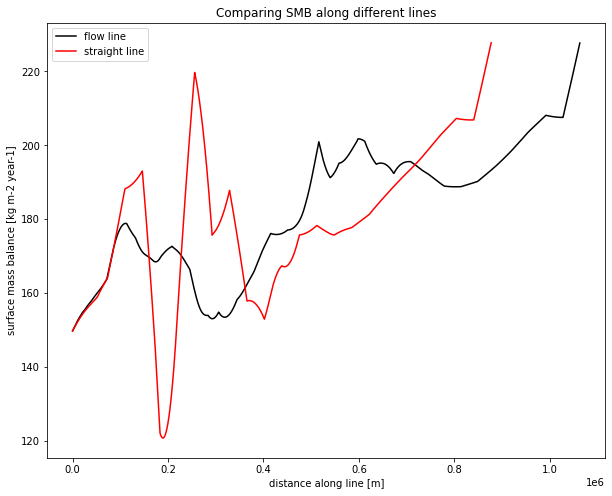

In [16]:
plt.figure(figsize=(10,8))
d = np.sqrt(np.diff(yi)**2 + np.diff(xi)**2)
d = np.insert(np.cumsum(d), 0 , 0)
plt.plot(d,smb_interp((yi,xi)),color='black',label='flow line')
d_s = np.sqrt(np.diff(y_straight)**2 + np.diff(x_straight)**2)
d_s = np.insert(np.cumsum(d_s), 0 , 0)
plt.plot(d_s,smb_interp((y_straight,x_straight)),color='red',label='straight line')
plt.ylabel('surface mass balance [kg m-2 year-1]')
plt.xlabel('distance along line [m]')
plt.legend()
plt.title('Comparing SMB along different lines')

Now let's try to apply values extracted from a flowline to a model. Let's find a flowline that is closer to a land-terminating portion of the ice sheet. We take advantage of our code snippet from Part 2 to select a point in East Antarctica. (In this example, I used coordinates around x=1391240,y=-389056)

<ipython-input-17-a69984a215eb>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');


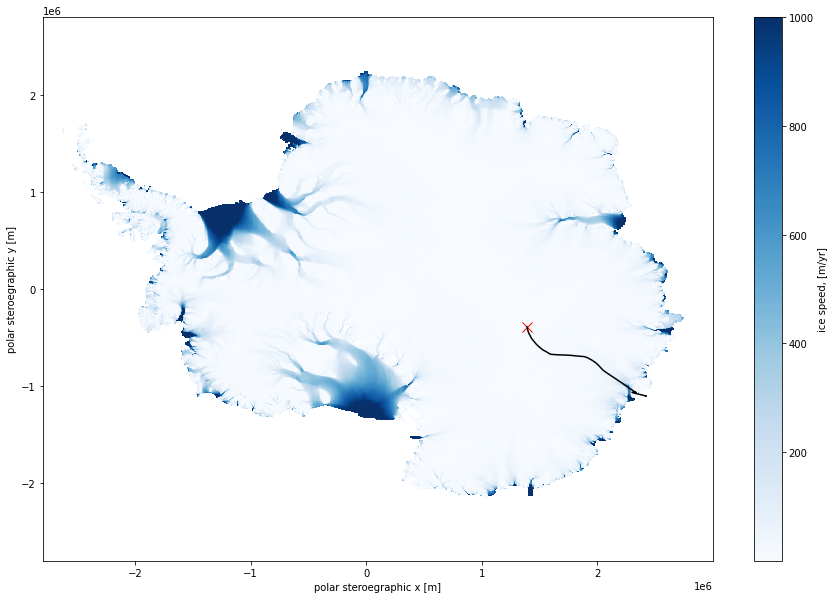

In [17]:
import matplotlib
#matplotlib.use( 'tkagg' )
plt.figure(figsize=(15,10))
speed = np.sqrt(Vx**2 + Vy**2)
speed[speed == 0] = 'nan'
plt.pcolormesh(X, Y, speed,vmax=1000, cmap = 'Blues');
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]');
plt.colorbar(label = 'ice speed, [m/yr]')
#p = plt.ginput(1)
#x1, y1 = p[0]
x1,y1 = 1391240,-389056
xi,yi = flow_from_grad(x1,y1,Vx,Vy,X,Y,1e6)
plt.plot(x1,y1,c='red',marker='x',ms=10)
plt.plot(xi,yi,color='black',label='pathline')

The model we use is the shallow ice approximation, reused from previous practicals.

In [18]:
n = 3                         # Glen's flow law exponent
A = 24e-25 *(365*24*60*60);    # Glen's flow law parameter original value from Cuffey and Paterson 24e-25
rho = 917                      # ice density
g = 9.8                        # acceleration due to gravity
u_calc = 2*A/(n+1)*(rho*g*smooth(slope_interp((yi,xi)))*smooth(thick_interp((yi,xi))))**n * smooth(thick_interp((yi,xi)))


We see that along the interior, the modeled velocities fits the measured velocities (near zero). Closer to the grounding line, the results get quite noisy, although they do seem to follow the general trend of the measured data. This is surprising as we expect SIA to fail near the grounding line, but here it seems to track it ok.

Text(0.5, 1.0, 'Comparing modeled and measured velocities')

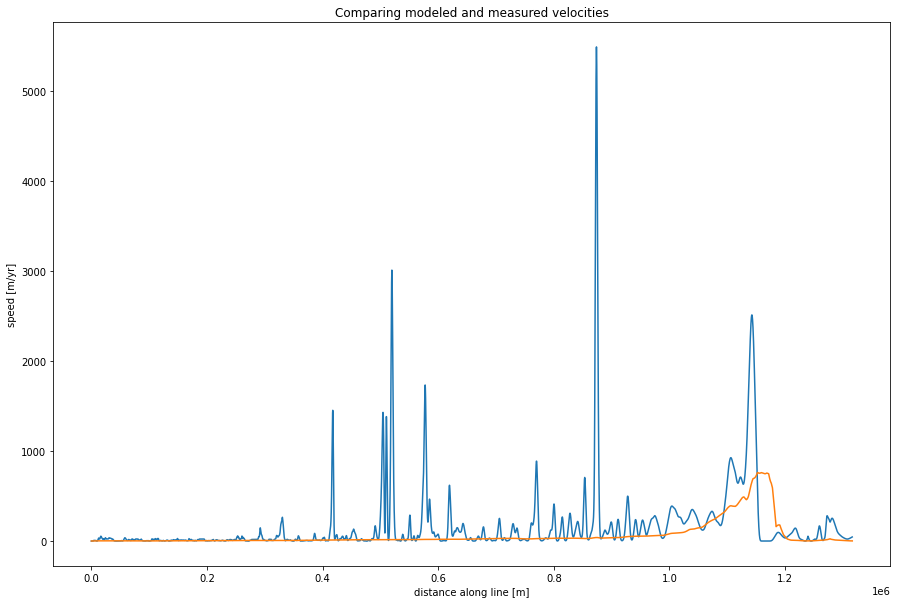

In [19]:
%matplotlib inline
d = np.sqrt(np.diff(yi)**2 + np.diff(xi)**2)
d = np.insert(np.cumsum(d), 0 , 0)
plt.figure(figsize=(15,10))
plt.plot(d,smooth(u_calc),label='modeled (SIA)')
plt.plot(d,speed_interp((yi,xi)),label='measured')
plt.ylabel('speed [m/yr]')
plt.xlabel('distance along line [m]')
plt.title('Comparing modeled and measured velocities')

This rather surprising fit with my specific example lead to a little side investigation tacked on at the end looking at how well SIA approximates velocities across the entire ice sheet. We try this by interpolating the measured velocities to the calculated velocity grid. First we calculate the velocities across the ice sheet using SIA and the measured thicknesses and slopes. We see that it is quite noisy. 

<ipython-input-20-b9bfcf14a267>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, vels_interp((Yg,Xg)),vmax=1000, cmap = 'Blues')


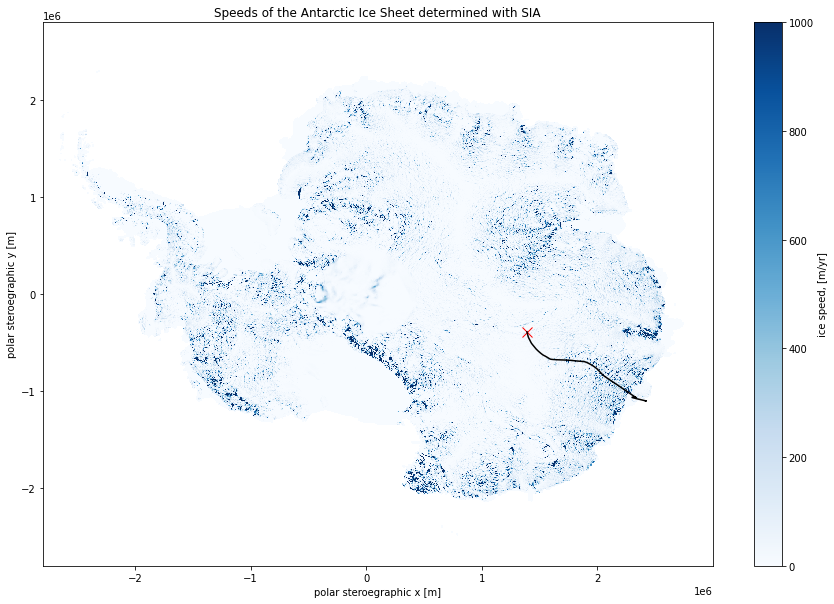

In [20]:
u_all = 2*A/(n+1)*(rho*g*slope*thickness)**n * thickness
vels_interp = scipy.interpolate.RegularGridInterpolator((y_bedmap, x_bedmap), u_all)
plt.figure(figsize=(15,10))
Xg, Yg = np.meshgrid(X,Y)
plt.pcolormesh(X, Y, vels_interp((Yg,Xg)),vmax=1000, cmap = 'Blues')
plt.title('Speeds of the Antarctic Ice Sheet determined with SIA')
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]')
plt.colorbar(label = 'ice speed, [m/yr]')
plt.plot(x1,y1,c='red',marker='x',ms=10)
plt.plot(xi,yi,color='black',label='pathline')

Interpolating this to the same grid as the measured velocities and taking the difference, we can see why our example flowline fits surprisingly well. Outside of some noisier areas outside of divides, SIA follows measured velocities quite well all the way to the terminus of the ice sheet, for portions that terminate on land. Consequently, in my example, I suspect the flowline reaches a land terminus, or a very small shelf. We also see that SIA does indeed grossly underestimate velocities past the grounding line.

<ipython-input-21-9afd22626e79>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, diff,vmin=-1000, vmax=1000,cmap = 'bwr')


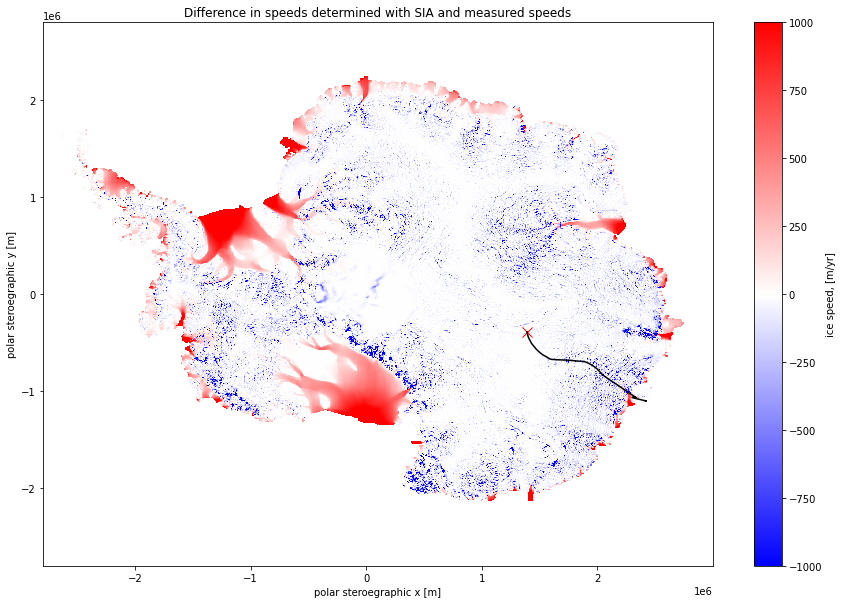

In [21]:
plt.figure(figsize=(15,10))
diff = speed - vels_interp((Yg,Xg))
plt.pcolormesh(X, Y, diff,vmin=-1000, vmax=1000,cmap = 'bwr')
plt.title('Difference in speeds determined with SIA and measured speeds')
plt.xlabel('polar steroegraphic x [m]')
plt.ylabel('polar steroegraphic y [m]')
plt.colorbar(label = 'ice speed, [m/yr]')
plt.plot(x1,y1,c='red',marker='x',ms=10)
plt.plot(xi,yi,color='black',label='pathline')

As a final check, we see that the slope doesn't flatten to zero as it would for a shelf, so we can conclude in this instance, we are indeed reaching a land-terminating portion. This sanity check takes advantage of our new ability to extract profiles along automatically-determined flowlines.

Text(0.5, 1.0, 'Slope along flowline')

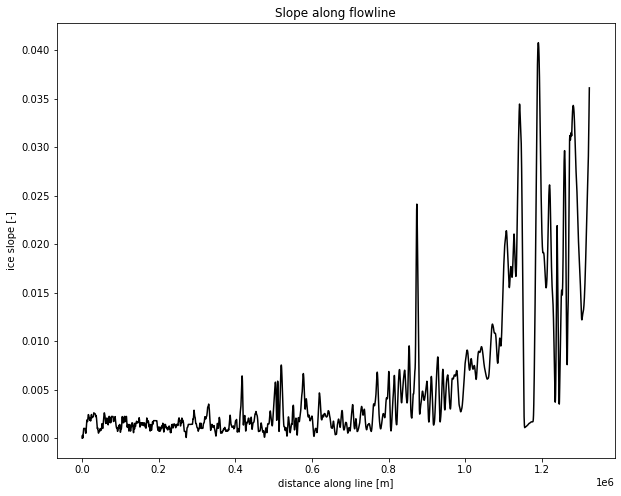

In [22]:
plt.figure(figsize=(10,8))
d = np.sqrt(np.diff(yi)**2 + np.diff(xi)**2)
d = np.insert(np.cumsum(d), 0 , 0)
plt.plot(d,smooth(slope_interp((yi,xi))),color='black',label='flow line')
plt.ylabel('ice slope [-]')
plt.xlabel('distance along line [m]')
plt.title('Slope along flowline')

In summary, this project has done the following:
- We have investigated 3 different methods of determining a flowline for any given point on an ice sheet, of varying degrees of success. Calculating pathlines through an initial value problem solution seems like the best approach.
- We implemented a code snippet that allows a user to specify a point on a map, and the code generates coordinates detailing the flowline. This snippet could be useful in a more formal app form for researchers that want to quickly figure out the flowlines for any given point on an ice sheet/glacier. 
- We used this flowline finder to evaluate the quality of data taken along a flowline compared with that taken along a straight line transect, and also used these values to evaluate a simple ice sheet model

There's many ways to take this further in the future. Ways of doing so include:
- Using other methods for finding flowlines, especially if the data comes from a singular measurement
- Packaging these calculations into an app where one could click on a map, select a relevant variable, and the app will spit out a profile of said variable along the flowline

## References
Agosta, C., & Fettweis, X. Antarctic surface mass balance with the regional climate model MAR (1979–2015) [Data set]. Zenodo. 2019. DOI: https://doi.org/10.5281/zenodo.2547638

Le Bris, R., Paul, F. An automatic method to create flow lines for determination of
glacier length: A pilot study with Alaskan glaciers. Computers Geosciences, 52(3):234-245 (2013).
DOI: https://doi.org/10.1016/j.cageo.2012.10.014

Radić, V., Bliss, A., Beedlow, A.C. et al. Regional and global projections of twenty-first century glacier mass changes in response to climate scenarios from global climate models. Clim Dyn 42, 37–58 (2014). DOI: https://doi.org/10.1007/s00382-013-1719-7